### Consolidação do processo

Este notebook apresenta o código relativo:
* ao processo de leitura e conversão dos ficheiros base (perc_cp_PTD.csv, processado através do QGIS, e consumos_4_digitos.csv, processado em notebook paralelo);
* à criação de funções de apoio ao processo de generalização para todo o país, que permitem a inputação de um endereço ou referencial, a identificação do PTD a ele correspondente e dos CPs que compõem seus consumos, a extração de dados de consumo e de radiação solar e o processo de identificação de correlações entre os padrões normalizados; e
* uma análise de caso relativa a um endereço (Estádio do Dragão), demonstrando os dados obtidos

Este é o código que serviu como base para a operacionalização do webapp

In [43]:
# Bibliotecas padrão
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import urllib.parse
import concurrent.futures
import logging

# Módulos para a parte espacial
import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import Point
from shapely import wkt

In [ ]:
# Leitura do CSV
df_ptds = pd.read_csv(r"../data/perc_cp_PTD.csv")

# Converter WKT para geometria
df_ptds["geometry"] = df_ptds["geometry"].apply(wkt.loads)

# Criar GeoDataFrame e definir o CRS original correto
df_ptds = gpd.GeoDataFrame(df_ptds, geometry='geometry', crs="EPSG:3857")

# Converter para EPSG:4326 se necessário
df_ptds = df_ptds.to_crs("EPSG:4326")

# Visualização
print(df_ptds.head())


   index_cp cod_postal          dd_desig  \
0     16910   2520-627            Leiria   
1     97890   4910-477  Viana do Castelo   
2     97863   4910-443  Viana do Castelo   
3     97842   4910-384  Viana do Castelo   
4     18901   2560-574            Lisboa   

                                            cc_desig   llll  \
0  Peniche                                       ...  35331   
1  Caminha                                       ...  11613   
2  Caminha                                       ...  11613   
3  Caminha                                       ...  11613   
4  Torres Vedras                                 ...  47802   

             LOCALIDADE   CP4  CP3                 CPALF   LATITUDE  \
0               Peniche  2520  627               PENICHE  39.361790   
1  Vila Praia de Âncora  4910  477  VILA PRAIA DE ÂNCORA  41.824709   
2  Vila Praia de Âncora  4910  443  VILA PRAIA DE ÂNCORA  41.825478   
3  Vila Praia de Âncora  4910  384  VILA PRAIA DE ÂNCORA  41.825204   
4

In [ ]:
# Leitura do CSV com os valores para 4 dígitos
df_4_digitos = pd.read_csv(r"../data/consumos_4_digitos.csv")

C:\Users\toto9\AppData\Local\Temp\ipykernel_39872\2169256298.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_4_digitos = pd.read_csv(r"./data/consumos_4_digitos.csv")


In [80]:
# logging simples (use debug=True nas funções para mais detalhe)
logging.basicConfig(level=logging.INFO, format="%(levelname)s | %(message)s", force=True)

# ── AUTO-COMPLETE ENDEREÇO (Photon) ────────────────────────────────────────
def autocomplete_address(query: str, limit: int = 5) -> list[dict]:
    url = f"https://photon.komoot.io/api/?q={query}&limit={limit}"
    r = requests.get(url, timeout=15)
    if r.status_code != 200:
        return []
    out = []
    for f in r.json()["features"]:
        p = f["properties"]
        out.append(
            dict(
                name=p.get("name", ""),
                city=p.get("city", ""),
                country=p.get("country", ""),
                lat=f["geometry"]["coordinates"][1],
                lon=f["geometry"]["coordinates"][0],
                full=f'{p.get("name","")}, {p.get("city","")}, {p.get("country","")}',
            )
        )
    return out


# ── MAPEAMENTO CP-4 → DATASET e-Redes ──────────────────────────────────────
DATASET_INTERVALS = [
    (1000, 2000, "1000a2000"),
    (2001, 2500, "2001a2500"),
    (2501, 2695, "2501a2695"),
    (2696, 2820, "2696a2820"),
    (2821, 3080, "2821a3080"),
    (3081, 3780, "3081a3780"),
    (3781, 4420, "3781a4420"),
    (4421, 4550, "4421a4550"),
    (4551, 4770, "4551a4770"),
    (4771, 5200, "4771a5200"),
    (5201, 7400, "5201a7400"),
    (7401, 8970, "7401a8970"),
]


def get_dataset_identifier(cp4: int) -> str:
    for a, b, s in DATASET_INTERVALS:
        if a <= cp4 <= b:
            return f"consumoshorariocodigopostal{s}"
    raise ValueError(f"CP4 {cp4} fora do intervalo 1000-8970.")


# ── CHAMADA PAGINADA À API ────────────────────────────────────────────────
def call_api(
    dataset_identifier: str,
    cp7: str,
    *,
    page_size: int = 20,
    max_registos: int | None = None,
) -> list[dict]:
    out, offset = [], 0
    while True:
        params = {
            "limit": page_size,
            "offset": offset,
            "refine": f'codigo_postal:"{cp7}"',
        }
        url = (
            "https://e-redes.opendatasoft.com/api/explore/v2.1/catalog/datasets/"
            f"{dataset_identifier}/records?"
            + urllib.parse.urlencode(params, safe=':"')
        )
        r = requests.get(url, timeout=30)
        if r.status_code != 200:
            print(f"⚠️ {r.status_code} ao buscar {cp7}")
            break
        js = r.json()
        out.extend(js.get("results", []))

        total = js.get("total_count", "?")
        print(
            f"📥 Pág.{offset//page_size+1}: +{len(js.get('results', []))}"
            f" (total {len(out)}/{total})"
        )
        if not js.get("results") or len(out) >= total:
            break
        if max_registos and len(out) >= max_registos:
            out = out[:max_registos]
            break
        offset += page_size
    print(f"✅ {len(out)} registos finais para {cp7}")
    return out


# ── PVGIS ─────────────────────────────────────────────────────────────────
def obter_irradiacao_pvgis(lat: float, lon: float) -> pd.DataFrame:
    url = "https://re.jrc.ec.europa.eu/api/seriescalc"
    p = {
        "lat": lat,
        "lon": lon,
        "startyear": 2020,
        "endyear": 2020,
        "outputformat": "json",
        "angle": 0,
        "aspect": 0,
        "global": 1,
        "localtime": 1,
        "usehorizon": 1,
        "pvcalculation": 0,
        "radiation_db": "PVGIS-SARAH2",
        "hourlyvalues": 1,
    }
    r = requests.get(url, params=p, timeout=30)
    r.raise_for_status()

    lst = []
    for h in r.json()["outputs"]["hourly"]:
        lst.append(
            dict(
                Latitude=lat,
                Longitude=lon,
                DataHora=pd.to_datetime(h["time"], format="%Y%m%d:%H%M")
                .replace(year=2024)
                .floor("h"),
                kWh_m2=h["G(i)"] / 1000,
            )
        )
    return pd.DataFrame(lst).rename(columns={"kWh_m2": "producao_kWh/m2"})


# ── WORKER POR CP-7 ───────────────────────────────────────────────────────
def _buscar_cp7(row: pd.Series) -> list[dict]:
    cp7 = row["cod_postal"]
    peso = row["percent_area_in_ptd"] / 100
    cp4 = int(cp7.split("-")[0])

    try:
        dataset = get_dataset_identifier(cp4)
    except ValueError as e:
        print(f"⏭️ {e}")
        return []

    print(f"\n🔎 Buscando {cp7} ({peso:.1%})…")
    reg = call_api(dataset, cp7)
    for r in reg:
        r["_ponderacao_cp"] = peso   # será usado no somatório ponderado
        r["_cp7"] = cp7
    return reg


# ── UTIL ─────────────────────────────────────────────────────────────────
def _drop_tz(s: pd.Series) -> pd.Series:
    """Remove timezone sem perder a information de hora."""
    return s.dt.tz_convert(None).dt.tz_localize(None) if getattr(s.dt, "tz", None) else s


# ── CONSOLIDA CONSUMO + IRRADIAÇÃO ───────────────────────────────────────
def consolidar_dados(df_cons: pd.DataFrame, df_irr: pd.DataFrame) -> pd.DataFrame:
    df_cons = df_cons.copy()
    df_cons["DataHora"] = _drop_tz(pd.to_datetime(df_cons["datahora"], utc=True))

    df_irr = df_irr.copy()
    df_irr["DataHora"] = _drop_tz(pd.to_datetime(df_irr["DataHora"]).dt.floor("h"))

    ano = df_cons["DataHora"].dt.year.min() if not df_cons.empty else 2024
    base = pd.date_range(f"{ano}-01-01", f"{ano}-12-31 23:00", freq="h")
    df_base = pd.DataFrame({"DataHora": base})

    df = (
        df_base.merge(df_cons[["DataHora", "consumo_ptd"]], on="DataHora", how="left")
        .merge(df_irr[["DataHora", "producao_kWh/m2"]], on="DataHora", how="left")
        .sort_values("DataHora")
        .reset_index(drop=True)
    )
    return df


# ── IMPUTAÇÃO (nova lógica) ───────────────────────────────────────────────
def imputar_consumo_restante(
    df_ptd: pd.DataFrame,           # DataHora + consumo_ptd + kWh/m2 (PTD)
    df_cp7: pd.DataFrame,           # registos hora-a-hora de cada CP-7, com _ponderacao_cp e _cp7
    df_4_digitos: pd.DataFrame,     # CP-4 x Dia_MM_DD x Consumo_normalizado
    cp_info: pd.DataFrame,          # CP-7 + percent_area_in_ptd
    *,
    dia_ref: str = "2024-02-10",
    debug: bool = False,
) -> pd.DataFrame:
    """
    Para cada hora faltante fora de Fevereiro:
        consumo_ptd = Σ (perfil horário 10-Fev do CP-7  ×  factor diário do CP-4 × peso_area)
    O factor diário = Consumo_normalizado(dia) / Consumo_normalizado(10-Fev) do mesmo CP-4.
    """
    # --- garantir que datahora é datetime -----------------------------
    df_cp7 = df_cp7.copy()
    df_cp7["datahora"] = pd.to_datetime(df_cp7["datahora"], utc=True)
    dia_ref_date = pd.to_datetime(dia_ref).date()

    # 1) perfil hora-a-hora de 10-Fev por CP-7 (já ponderado pela área)
    perfis = (
        df_cp7[df_cp7["datahora"].dt.date == dia_ref_date]
        .merge(cp_info[["cod_postal", "percent_area_in_ptd"]],
               left_on="_cp7", right_on="cod_postal")
        .assign(
            hora=lambda d: d["datahora"].dt.hour,
            peso=lambda d: d["percent_area_in_ptd"] / 100,
            base_kwh=lambda d: d["consumo"] * d["peso"],
            CP4=lambda d: d["_cp7"].str[:4].astype(int),
        )
    )
    if perfis.empty or perfis["hora"].nunique() < 24:
        raise ValueError("10-Fev não contém 24 valores por CP-7.")

    base_cp7 = (
        perfis.pivot_table(index="hora", columns="_cp7", values="base_kwh")
        .sort_index()
    )  # (24 h × n_cp7)

    # 2) factor diário por CP-4
    df4 = df_4_digitos.rename(columns={"Código Postal": "CP4"}).copy()

    # --- garantir CP4 como inteiro -----------------------------------------
    df4["CP4"] = (
        df4["CP4"]
        .astype(str)                 # ex.: " 8500 "
        .str.extract(r"(\d{4})")[0]  # apenas os 4 dígitos
    )

    # remove linhas sem CP4 válido
    df4 = df4.dropna(subset=["CP4"])

    # converte para inteiro real
    df4["CP4"] = df4["CP4"].astype(int)
    # -----------------------------------------------------------------------


    df4["Data"] = pd.to_datetime("2024-" + df4["Dia_MM_DD"]).dt.date

    ref_10fev = (
        df4[df4["Data"] == dia_ref_date]
        .set_index("CP4")["Consumo_normalizado"]
        .rename("ref_10fev")
    )
    fatores = (
        df4.set_index(["CP4", "Data"])["Consumo_normalizado"]
        .div(ref_10fev)
        .unstack(level=0)           # datas × CP-4
    )

    # 3) factor diário mapeado a cada CP-7
    mapa_cp7_cp4 = perfis.drop_duplicates("_cp7").set_index("_cp7")["CP4"]
    fatores_cp7 = fatores.loc[:, mapa_cp7_cp4.values]
    fatores_cp7.columns = mapa_cp7_cp4.index  # colunas = CP-7

    # ── novo: índice diário completo e ffill  ────────────────────────────
    idx_full = pd.date_range("2024-01-01", "2024-12-31", freq="D").date
    fatores_cp7 = (
        fatores_cp7
        .reindex(idx_full)   # adiciona dias em falta (ex.: 31-Out)
        .sort_index()
        .ffill()             # forward-fill ⇒ 31-Out recebe valor de 30-Out
    )


    # 4) calendário completo
    calendario = pd.date_range("2024-01-01", "2024-12-31 23:00", freq="h", tz=None)
    df_out = (
        pd.DataFrame({"DataHora": calendario})
        .merge(df_ptd[["DataHora", "consumo_ptd", "producao_kWh/m2"]], on="DataHora", how="left")
        .sort_values("DataHora")
        .reset_index(drop=True)
    )

    # 5) imputação
    mask_nan = df_out["consumo_ptd"].isna() & (df_out["DataHora"].dt.month != 2)
    if debug:
        logging.info("Total de horas a imputar: %d", mask_nan.sum())

    for dt_date in df_out.loc[mask_nan, "DataHora"].dt.date.unique():
        if dt_date == dia_ref_date or dt_date not in fatores_cp7.index:
            continue
        vec_factor = fatores_cp7.loc[dt_date]          # Série (index = CP-7)
        estim_horas = base_cp7.mul(vec_factor, axis=1).sum(axis=1)
        idxs = df_out.index[df_out["DataHora"].dt.date == dt_date]
        df_out.loc[idxs, "consumo_ptd"] = estim_horas.values

    return df_out

# ── NORMALIZAÇÃO + CORRELAÇÃO POR PTD ──────────────────────────────────────
def normalizar_e_corrigir_por_dia(
    df: pd.DataFrame,
    limiar: float = 0.02,
    col_ts: str = "DataHora",
) -> dict[int, float]:
    """
    Correlação consumo × irradiação por PTD, após normalizar min-max por dia.
    Ignora horas 23-04 e só considera irradiância > limiar.

    Requer colunas:
        • id_PTD
        • consumos      (kWh)
        • irradiacao    (kWh/m²)
        • DataHora
    """
    resultados: dict[int, float] = {}
    dados = df.copy()
    dados["dia"]  = dados[col_ts].dt.floor("D")
    dados["hora"] = dados[col_ts].dt.hour

    # mantém apenas horas 05‒22
    dados = dados[dados["hora"].between(5, 22)]

    for id_ptd, g in dados.groupby("id_PTD"):
        g = g[g["irradiacao"] > limiar]          # só horas com irradiância “útil”
        if g.empty:
            continue

        def escalar(s: pd.Series):
            rng = s.max() - s.min()
            return (s - s.min()) / rng if rng != 0 else 0.0

        g["cons_norm"]  = g.groupby("dia")["consumos"].transform(escalar)
        g["irr_norm"]   = g.groupby("dia")["irradiacao"].transform(escalar)

        if g["cons_norm"].nunique() > 1 and g["irr_norm"].nunique() > 1:
            resultados[id_ptd] = g["cons_norm"].corr(g["irr_norm"])

    return resultados

# ── FUNÇÃO PRINCIPAL ──────────────────────────────────────────────────────
def processar_endereco(
    df_ptds: gpd.GeoDataFrame,
    df_4_digitos: pd.DataFrame,
    *,
    debug: bool = False,
) -> pd.DataFrame | None:
    """Fluxo completo: escolher endereço, descarregar dados, imputar e devolver DataFrame."""
    q = input("Digite o endereço ou parte dele: ")
    s = autocomplete_address(q)
    if not s:
        print("Nenhuma sugestão.")
        return
    for i, e in enumerate(s):
        print(f"{i}: {e['full']}")
    sel = s[int(input("Escolha nº: "))]

    # qual PTD contém o ponto?
    ponto = (
        gpd.GeoSeries([Point(sel["lon"], sel["lat"])], crs=4326)
        .to_crs(df_ptds.crs)
        .iloc[0]
    )
    match = df_ptds[df_ptds.contains(ponto)]
    if match.empty:
        print("❌ Fora de qualquer PTD.")
        return

    idx_ptd = match.iloc[0]["index_ptd"]
    print(f"✅ index_ptd: {idx_ptd}")

    cp_info = (
        df_ptds[df_ptds["index_ptd"] == idx_ptd][["cod_postal", "percent_area_in_ptd"]]
        .drop_duplicates()
        .reset_index(drop=True)
    )
    lat, lon = match.iloc[0][["LATITUDE", "LONGITUDE"]]

    dados, max_workers = [], max(4, min(10, len(cp_info) + 1))
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as ex:
        futs_cp = [ex.submit(_buscar_cp7, r) for _, r in cp_info.iterrows()]
        fut_irr = ex.submit(obter_irradiacao_pvgis, lat, lon)

        for f in concurrent.futures.as_completed(futs_cp):
            dados.extend(f.result())

        try:
            df_irr = fut_irr.result()
        except Exception as e:
            print(f"⚠️ PVGIS falhou: {e}")
            df_irr = pd.DataFrame()

    if not dados:
        print("⚠️ Sem dados de consumo.")
        return pd.DataFrame()

    # --- agregação para o PTD (consumo ponderado)
    df_cp7 = pd.DataFrame(dados)
    df_cp7["consumo_ponderado"] = df_cp7["consumo"] * df_cp7["_ponderacao_cp"]
    df_cons = (
        df_cp7.groupby("datahora", as_index=False)["consumo_ponderado"]
        .sum()
        .rename(columns={"consumo_ponderado": "consumo_ptd"})
    )

        # --- consolida + imputação
    df_ptd = consolidar_dados(df_cons, df_irr)
    df_ptd = imputar_consumo_restante(
        df_ptd,
        df_cp7,
        df_4_digitos,
        cp_info,
        debug=debug,
    )

    # ------------- CORRELAÇÃO consumo × irradiação -------------------------
    df_corr = df_ptd.rename(columns={
        "consumo_ptd": "consumos",
        "producao_kWh/m2": "irradiacao"
    }).copy()
    df_corr["id_PTD"] = idx_ptd

    corr_dict = normalizar_e_corrigir_por_dia(df_corr)
    correlacao_ptd = corr_dict.get(idx_ptd, float("nan"))

    print("\n📈 Primeiras linhas após imputação:")
    print(df_ptd.head(20))
    print(f"\n🔗 Correlação consumo × irradiação para o PTD {idx_ptd}: "
          f"{correlacao_ptd:.3f}")

    # ----------------------------------------------------------------------
    # devolve dataframe + correlação
    return df_ptd, correlacao_ptd, idx_ptd

    # ── GRÁFICO DO DIA MÉDIO NORMALIZADO ──────────────────────────────────────


def plot_dia_medio_normalizado(
    df: pd.DataFrame,
    id_ptd: int,
    *,
    col_ts: str = "DataHora",
    col_cons: str = "consumo_ptd",
    col_irr: str = "producao_kWh/m2",
):
    """
    Exibe o padrão diário médio normalizado (0-1) de consumo × irradiação
    para o PTD indicado.

    Parâmetros
    ----------
    df        : DataFrame com pelo menos col_ts, col_cons, col_irr, id_PTD
    id_ptd    : inteiro do PTD a mostrar
    col_ts    : nome da coluna datetime (default 'DataHora')
    col_cons  : nome da coluna de consumo (default 'consumo_ptd')
    col_irr   : nome da coluna de irradiação (default 'producao_kWh/m2')
    """
    df = df.copy()
    df = df[df["id_PTD"] == id_ptd]

    if df.empty:
        print(f"Nenhum dado para PTD {id_ptd}.")
        return

    df[col_ts] = pd.to_datetime(df[col_ts])
    df["hour"] = df[col_ts].dt.hour

    media_horaria = (
        df.groupby("hour")[[col_cons, col_irr]]
        .mean()
        .reset_index()
        .rename(columns={col_cons: "cons_media", col_irr: "irr_media"})
    )

    # normalização min-max
    def norm(s):
        rng = s.max() - s.min()
        return (s - s.min()) / rng if rng != 0 else 0.0

    media_horaria["cons_norm"] = norm(media_horaria["cons_media"])
    media_horaria["irr_norm"]  = norm(media_horaria["irr_media"])

    # ­­­­­ Plot
    plt.figure(figsize=(10, 5))
    plt.plot(
        media_horaria["hour"],
        media_horaria["cons_norm"],
        label="Consumo médio (norm.)",
        linewidth=2,
    )
    plt.plot(
        media_horaria["hour"],
        media_horaria["irr_norm"],
        label="Irradiação média (norm.)",
        linewidth=2,
        color="orange",
    )
    plt.title(f"Padrão Diário Médio Normalizado – PTD {id_ptd}")
    plt.xlabel("Hora do dia")
    plt.ylabel("Valor normalizado")
    plt.xticks(range(0, 24))
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

0: Estádio do Dragão, Porto, Portugal
1: Estádio do Dragão, Porto, Portugal
2: Museu Futebol Clube do Porto, Porto, Portugal
3: Estádio do Dragão, Porto, Portugal
4: Estádio do Dragão, Porto, Portugal
✅ index_ptd: 28772

🔎 Buscando 4350-316 (5.2%)…

🔎 Buscando 4300-360 (14.0%)…

🔎 Buscando 4350-417 (24.5%)…

🔎 Buscando 4300-111 (6.8%)…

🔎 Buscando 4350-415 (61.2%)…

🔎 Buscando 4350-214 (11.6%)…

🔎 Buscando 4350-095 (0.1%)…
📥 Pág.1: +0 (total 0/0)
✅ 0 registos finais para 4350-214
📥 Pág.1: +0 (total 0/0)
✅ 0 registos finais para 4350-316
📥 Pág.1: +20 (total 20/673)
📥 Pág.1: +20 (total 20/696)
📥 Pág.1: +20 (total 20/694)
📥 Pág.1: +20 (total 20/696)
📥 Pág.1: +20 (total 20/696)
📥 Pág.2: +20 (total 40/696)
📥 Pág.2: +20 (total 40/673)
📥 Pág.2: +20 (total 40/696)
📥 Pág.2: +20 (total 40/696)
📥 Pág.2: +20 (total 40/694)
📥 Pág.3: +20 (total 60/696)📥 Pág.3: +20 (total 60/673)

📥 Pág.3: +20 (total 60/696)
📥 Pág.3: +20 (total 60/694)
📥 Pág.3: +20 (total 60/696)
📥 Pág.4: +20 (total 80/696)
📥 Pág.4: 

C:\Users\toto9\AppData\Local\Temp\ipykernel_39872\878890394.py:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g["cons_norm"]  = g.groupby("dia")["consumos"].transform(escalar)
C:\Users\toto9\AppData\Local\Temp\ipykernel_39872\878890394.py:319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g["irr_norm"]   = g.groupby("dia")["irradiacao"].transform(escalar)



📈 Primeiras linhas após imputação:
              DataHora  consumo_ptd  producao_kWh/m2
0  2024-01-01 00:00:00   315.411822          0.00000
1  2024-01-01 01:00:00   289.559006          0.00000
2  2024-01-01 02:00:00   257.282063          0.00000
3  2024-01-01 03:00:00   298.990955          0.00000
4  2024-01-01 04:00:00   287.143831          0.00000
5  2024-01-01 05:00:00   334.371068          0.00000
6  2024-01-01 06:00:00   362.526851          0.00000
7  2024-01-01 07:00:00   414.283083          0.00000
8  2024-01-01 08:00:00   539.419982          0.00000
9  2024-01-01 09:00:00   677.129007          0.13701
10 2024-01-01 10:00:00   691.751183          0.27901
11 2024-01-01 11:00:00   705.548327          0.38701
12 2024-01-01 12:00:00   842.588119          0.44301
13 2024-01-01 13:00:00   720.246300          0.43301
14 2024-01-01 14:00:00   697.174388          0.37901
15 2024-01-01 15:00:00   697.754366          0.27001
16 2024-01-01 16:00:00   721.793416          0.05000
17 2024-01

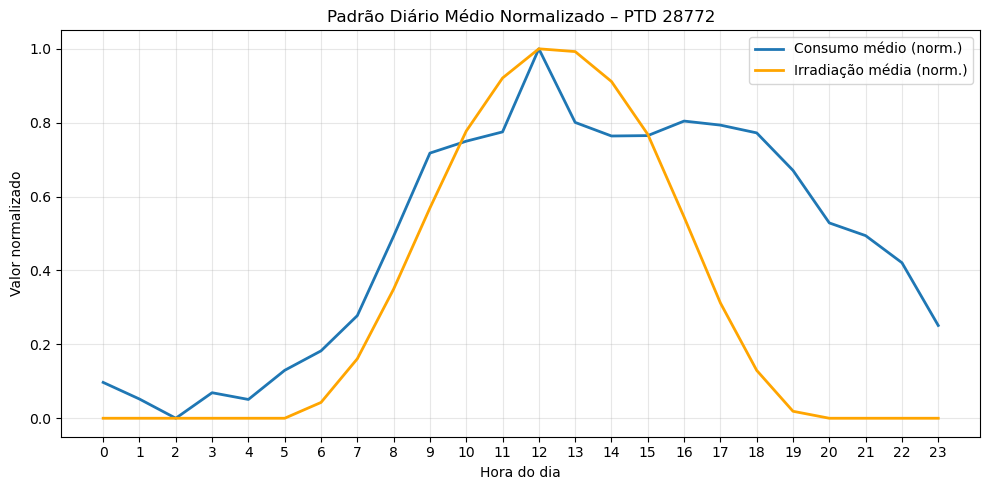

In [ ]:
df_dados_final, corr, idx_ptd = processar_endereco(df_ptds, df_4_digitos)

# adicionar coluna id_PTD caso já não exista
df_dados_final["id_PTD"] = df_dados_final.get("id_PTD", idx_ptd)  # idx_ptd devolvido antes

plot_dia_medio_normalizado(df_dados_final, idx_ptd)

In [82]:
df_dados_final.head(20)

,DataHora,consumo_ptd,producao_kWh/m2,id_PTD
0,2024-01-01 00:00:00,315.411822,0.00000,28772
1,2024-01-01 01:00:00,289.559006,0.00000,28772
2,2024-01-01 02:00:00,257.282063,0.00000,28772
3,2024-01-01 03:00:00,298.990955,0.00000,28772
4,2024-01-01 04:00:00,287.143831,0.00000,28772
5,2024-01-01 05:00:00,334.371068,0.00000,28772
6,2024-01-01 06:00:00,362.526851,0.00000,28772
7,2024-01-01 07:00:00,414.283083,0.00000,28772
8,2024-01-01 08:00:00,539.419982,0.00000,28772
9,2024-01-01 09:00:00,677.129007,0.13701,28772


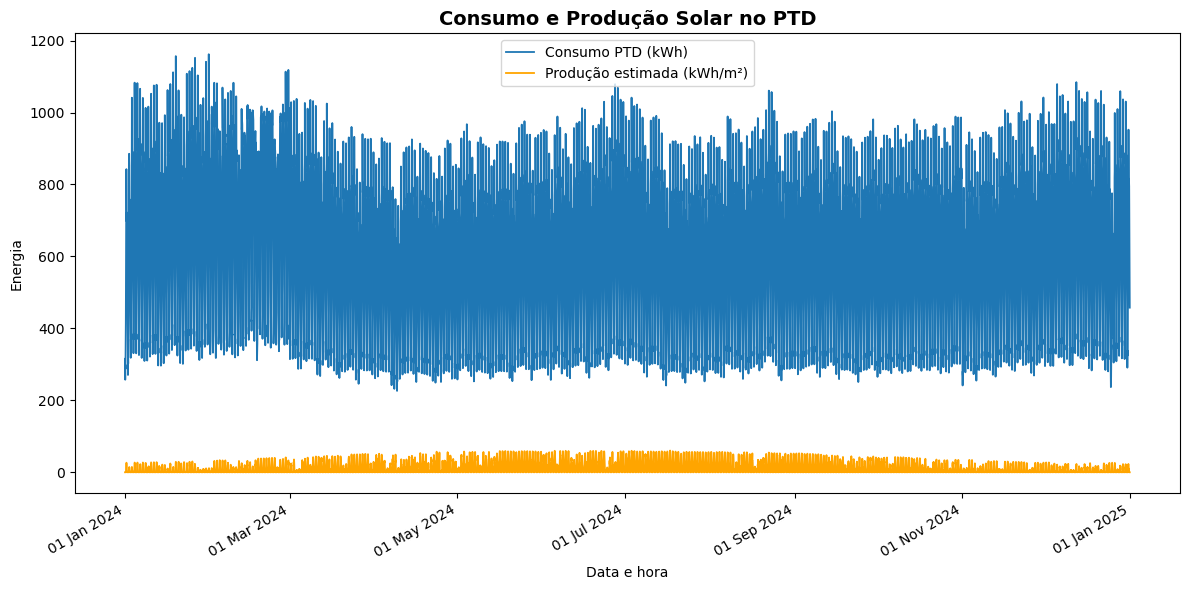

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# 1) Garantir que a coluna DataHora esteja em datetime
df_dados_final['DataHora'] = pd.to_datetime(df_dados_final['DataHora'])

# 2) Ordenar pelo tempo
df_dados_final = df_dados_final.sort_values('DataHora')

# 3) Plot
fig, ax = plt.subplots(figsize=(12, 6))

# Linha azul: consumo
ax.plot(df_dados_final['DataHora'],
        df_dados_final['consumo_ptd'],
        label='Consumo PTD (kWh)',
        linewidth=1.3)

# Linha laranja: produção (irradiação)
if 'producao_kWh/m2' in df_dados_final.columns:
    ax.plot(df_dados_final['DataHora'],
            df_dados_final['producao_kWh/m2'] * 60,
            label='Produção estimada (kWh/m²)',
            color='orange',
            linewidth=1.3)

# 4) Rótulos e formatação
ax.set_title('Consumo e Produção Solar no PTD', fontsize=14, weight='bold')
ax.set_xlabel('Data e hora')
ax.set_ylabel('Energia')

# Formatar o eixo de datas
ax.xaxis.set_major_formatter(DateFormatter('%d %b %Y'))
fig.autofmt_xdate()

# 5) Legenda
ax.legend()

plt.tight_layout()
plt.show()
